In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Set
import time
import random

size = 8
attempts = 500

PASTEL_COLORS = {
    # Chessboard colors
    'neutral': '#f5f1e8',      # Very light cream
    'dark': '#d4c4a8',         # Soft beige
    'queen': '#8b5a5a',        # Muted burgundy
    
    # Chart colors - soft pastels
    'success': '#a8d8a8',      # Soft mint green
    'failed': '#f4c2c2',       # Soft coral
    'found': '#ffd6a3',        # Soft peach
    'remaining': '#e6e6e6',    # Light gray
    'primary': '#b3d9ff',      # Soft sky blue
    'secondary': '#d4b3ff',    # Soft lavender
    'accent1': '#ffb3d9',      # Soft pink
    'accent2': '#b3ffb3',      # Soft mint
    'accent3': '#ffccb3',      # Soft orange
    'accent4': '#ffffb3',      # Soft yellow
    
    # Bar chart colors
    'bar1': '#c8e6c9',         # Soft green
    'bar2': '#bbdefb',         # Soft blue
    'bar3': '#f8bbd9',         # Soft pink
    'bar4': '#fff2cc',         # Soft yellow
    'bar5': '#e1bee7',         # Soft purple
    'bar6': '#ffcccb',         # Soft red
    
    # Performance colors
    'time_total': '#dcedc1',   # Soft sage
    'time_per': '#ffd3a5',     # Soft apricot
    
    # Grid and border colors
    'grid': '#cccccc',         # Soft gray
    'border': '#999999',       # Medium gray
    'text': '#555555'          # Soft dark gray
}

# Convenience shortcuts
COLORS = PASTEL_COLORS  # Keep backward compatibility

# Optional: Set matplotlib style for even softer appearance
#plt.style.use('seaborn-v0_8-whitegrid')  # or 'default' if seaborn not available
plt.style.use('default')
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelcolor'] = PASTEL_COLORS['text']
plt.rcParams['xtick.color'] = PASTEL_COLORS['text']
plt.rcParams['ytick.color'] = PASTEL_COLORS['text']

# Try to set a font that supports chess symbols (optional)
try:
    plt.rcParams['font.family'] = ['DejaVu Sans', 'Segoe UI Symbol', 'Arial']
except:
    pass  # Use default font if none available

In [2]:
class NQueensValidator:
    """
    N-Queens solution validator
    """
    
    def __init__(self, n: int):
        self.n = n
        self.checks = 0
        self.valid_solutions = set()
        self.vqe_found = set()
    
    def is_valid(self, positions: List[int], source: str = "unknown") -> bool:
        """
        Check validity of N-Queens solution
        """
        self.checks += 1
        
        if len(positions) != self.n:
            return False
        
        if any(p < 0 or p >= self.n for p in positions):
            return False
        
        # Check columns (should be automatically OK for sequential)
        if len(set(positions)) != self.n:
            return False
        
        # Check diagonals
        for i in range(self.n):
            for j in range(i + 1, self.n):
                if abs(positions[i] - positions[j]) == abs(i - j):
                    return False
        
        # Valid solution!
        solution = tuple(positions)
        self.valid_solutions.add(solution)
        
        if source == "vqe":
            self.vqe_found.add(solution)
        
        return True
    
    def check_partial_validity(self, positions: List[int]) -> bool:
        """
        Check partial validity for sequential building
        """
        n_placed = len(positions)
        
        # Check that all positions are within range
        if any(p < 0 or p >= self.n for p in positions):
            return False
        
        # Check that no two queens are in the same row
        if len(set(positions)) != n_placed:
            return False
        
        # Check diagonals between already placed queens
        for i in range(n_placed):
            for j in range(i + 1, n_placed):
                if abs(positions[i] - positions[j]) == abs(i - j):
                    return False
        
        return True

In [3]:
class VQEColumnSolver:
    """
    VQE solver - VQE measurements directly decide choices
    """
    
    def __init__(self, n: int):
        self.n = n
        self.simulator = AerSimulator()
        
        print(f"VQE N-Queens {n}×{n}")
        print(f"Strategy: Direct VQE measurement-driven choices")
    
    def get_available_rows(self, column: int, placed_queens: List[int]) -> Set[int]:
        """
        Find available rows for a queen in column 'column'
        """
        available = set(range(self.n))
        
        for prev_col, prev_row in enumerate(placed_queens):
            # Remove already used row
            available.discard(prev_row)
            
            # Remove diagonally conflicting rows
            diagonal_distance = column - prev_col
            
            # Main diagonal (/)
            conflicting_row1 = prev_row + diagonal_distance
            if 0 <= conflicting_row1 < self.n:
                available.discard(conflicting_row1)
            
            # Anti-diagonal (\)
            conflicting_row2 = prev_row - diagonal_distance
            if 0 <= conflicting_row2 < self.n:
                available.discard(conflicting_row2)
        
        return available
    
    def create_vqe_hamiltonian_circuit(self, available_rows: Set[int], placed_queens: List[int], 
                                      column: int, vqe_params: List[float]) -> QuantumCircuit:
        """
        Create VQE circuit with cost function encoded into quantum Hamiltonian
        """
        available_list = sorted(list(available_rows))
        n_options = len(available_list)
        
        if n_options == 0:
            raise ValueError("No available rows!")
        
        if n_options == 1:
            return None, available_list[0]
        
        # Number of qubits needed
        n_qubits = max(1, int(np.ceil(np.log2(n_options))))
        
        qc = QuantumCircuit(n_qubits, n_qubits)
        
        # ENHANCED VQE ansatz with cost-aware parameter encoding
        self._apply_cost_aware_vqe_ansatz(qc, vqe_params, available_list, placed_queens, column)

        qc.measure(range(n_qubits), range(n_qubits))
        
        return qc, available_list
    
    def _apply_cost_aware_vqe_ansatz(self, qc: QuantumCircuit, params: List[float], 
                                    available_rows: List[int], placed_queens: List[int], column: int):
        """
        VQE ansatz with cost function encoded into rotation angles
        """
        n_qubits = qc.num_qubits
        n_options = len(available_rows)
        
        # Calculate basic costs for each available row
        row_costs = {}
        for row in available_rows:
            cost = self._calculate_quantum_cost(row, placed_queens, column)
            row_costs[row] = cost
        
        # Normalize costs to rotation angles (lower cost = higher amplitude)
        max_cost = max(row_costs.values()) if row_costs else 1.0
        min_cost = min(row_costs.values()) if row_costs else 0.0
        cost_range = max_cost - min_cost if max_cost != min_cost else 1.0
        
        # Initialization - equal superposition
        qc.h(range(n_qubits))
        
        # COST-BIASED ROTATION LAYERS
        param_idx = 0
        for layer in range(3):  # 3 layers for better expressivity
            
            # RY rotations biased by costs
            for qubit in range(n_qubits):
                if param_idx < len(params):
                    base_angle = params[param_idx]
                    
                    # Cost bias: penalize high-cost measurements
                    cost_bias = 0.0
                    for measurement_val in range(2**n_qubits):
                        if measurement_val < n_options:
                            row = available_rows[measurement_val % n_options]
                            normalized_cost = (row_costs[row] - min_cost) / cost_range
                            # Higher cost = more negative bias (rotates away from |1⟩)
                            cost_bias += normalized_cost * 0.5  # Reduced bias for subtle effect
                    
                    cost_bias /= min(2**n_qubits, n_options)  # Average bias
                    
                    # Apply rotation: base_angle modified by cost bias
                    rotation_angle = base_angle - cost_bias * np.pi * 0.3  # Subtle cost influence
                    qc.ry(rotation_angle, qubit)
                    param_idx += 1
            
            # Entanglement layer
            for i in range(n_qubits - 1):
                qc.cx(i, i + 1)
            if n_qubits > 2:
                qc.cx(n_qubits - 1, 0)  # Circular entanglement
        
        # FINAL COST-WEIGHTED LAYER
        for qubit in range(n_qubits):
            if param_idx < len(params):
                # Strong cost bias in final layer
                cost_weight = 0.0
                for measurement_val in range(min(2**n_qubits, n_options)):
                    row = available_rows[measurement_val]
                    normalized_cost = (row_costs[row] - min_cost) / cost_range
                    # Lower cost rows get positive rotation (towards higher amplitude)
                    cost_weight += (1.0 - normalized_cost) * 0.8
                
                cost_weight /= min(2**n_qubits, n_options)
                
                final_angle = params[param_idx] + cost_weight * np.pi * 0.4
                qc.ry(final_angle, qubit)
                param_idx += 1
    
    def _calculate_quantum_cost(self, row_choice: int, placed_queens: List[int], column: int) -> float:
        """
        Simplified cost function for quantum encoding
        """
        cost = 0.0
        
        # Future constraints cost
        temp_queens = placed_queens + [row_choice]
        
        # Look ahead 2-3 columns
        for future_col in range(column + 1, min(column + 3, self.n)):
            future_available = self.get_available_rows(future_col, temp_queens)
            if len(future_available) == 0:
                cost += 10.0  # Dead end penalty
            elif len(future_available) == 1:
                cost += 2.0   # Forced move penalty
            else:
                cost -= len(future_available) * 0.5  # Bonus for flexibility
        
        # Position preferences (subtle)
        center = self.n // 2
        distance_from_center = abs(row_choice - center)
        cost += distance_from_center * 0.3  # Slight preference for center
        
        return cost
    
    def vqe_column_choice(self, column: int, placed_queens: List[int], 
                              attempt_number: int = 0) -> int:
        """
        VQE: Row selection directly from VQE measurements
        """
        available_rows = self.get_available_rows(column, placed_queens)
        
        print(f"  Column {column}: {len(available_rows)} available rows: {sorted(available_rows)}")
        
        if len(available_rows) == 0:
            raise ValueError(f"No available rows for column {column}!")
        
        if len(available_rows) == 1:
            chosen_row = list(available_rows)[0]
            print(f"    VQE: row {chosen_row} (deterministic)")
            return chosen_row
        
        # VQE optimization - systematically vary VQE parameters
        available_list = sorted(list(available_rows))
        n_options = len(available_list)
        n_qubits = max(1, int(np.ceil(np.log2(n_options))))
        
        # Systematic VQE parameter exploration based on attempt_number
        vqe_strategy = attempt_number % 5
        
        if vqe_strategy == 0:      # Conservative exploration
            param_range = np.pi * 0.5
            param_bias = 0.0
        elif vqe_strategy == 1:    # Aggressive exploration  
            param_range = np.pi * 1.5
            param_bias = np.pi * 0.3
        elif vqe_strategy == 2:    # Balanced
            param_range = np.pi * 1.0
            param_bias = np.pi * 0.1
        elif vqe_strategy == 3:    # High-variance
            param_range = np.pi * 2.0
            param_bias = np.pi * 0.5
        else:                      # Low-bias
            param_range = np.pi * 0.8
            param_bias = -np.pi * 0.2
        
        print(f"    VQE strategy {vqe_strategy}: range={param_range:.2f}, bias={param_bias:.2f}")
        
        # Run multiple VQE iterations for stability
        best_distribution = None
        best_entropy = -1
        
        for vqe_iter in range(15):  # Multiple VQE runs
            # Generate VQE parameters with systematic variation
            base_params = np.random.uniform(-param_range, param_range, 4 * n_qubits)
            base_params += param_bias  # Add systematic bias
            
            # Add attempt-specific systematic variation
            systematic_variation = np.sin(np.arange(len(base_params)) * attempt_number * 0.5) * 0.3
            vqe_params = base_params + systematic_variation
            
            try:
                # Create and run VQE circuit
                qc, _ = self.create_vqe_hamiltonian_circuit(available_rows, placed_queens, column, vqe_params)
                if qc is None:
                    continue
                
                transpiled = transpile(qc, self.simulator, optimization_level=1)
                job = self.simulator.run(transpiled, shots=1000)
                result = job.result()
                counts = result.get_counts()
                
                # Calculate entropy of distribution (prefer balanced distributions)
                total_shots = sum(counts.values())
                probs = [counts.get(format(i, f'0{n_qubits}b'), 0) / total_shots for i in range(2**n_qubits)]
                entropy = -sum(p * np.log2(p + 1e-10) for p in probs if p > 0)
                
                if entropy > best_entropy:
                    best_entropy = entropy
                    best_distribution = counts
                    
            except Exception as e:
                continue
        
        if best_distribution is None:
            # Fallback: random choice from available
            chosen_row = random.choice(available_list)
            print(f"    VQE FALLBACK: row {chosen_row}")
            return chosen_row
        
        # VQE CHOICE: Sample directly from quantum measurements
        total_shots = sum(best_distribution.values())
        
        # Create weighted choices from VQE measurements
        weighted_choices = []
        for bitstring, count in best_distribution.items():
            measurement_value = int(bitstring, 2) % n_options
            row_choice = available_list[measurement_value]
            weighted_choices.extend([row_choice] * count)
        
        # Direct sampling from VQE distribution
        if weighted_choices:
            chosen_row = random.choice(weighted_choices)
        else:
            chosen_row = random.choice(available_list)
        
        print(f"    VQE CHOICE: row {chosen_row}")
        print(f"      VQE distribution: {[(format(int(k, 2) % n_options, 'd'), v) for k, v in list(best_distribution.items())[:4]]}")
        
        return chosen_row

In [4]:
class VQENQueensSolver:
    """
    Main VQE solver
    """
    
    def __init__(self, n: int):
        self.n = n
        self.validator = NQueensValidator(n)
        self.column_solver = VQEColumnSolver(n)
    
    def solve_vqe(self, attempts: int = 20) -> Tuple[List, Dict]:
        """
        Solve N-Queens with VQE approach
        """
        print(f"VQE N-QUEENS {self.n}×{self.n}")
        print("-"*70)
        print("VQE measurements directly drive all choices")
        
        start_time = time.time()
        
        all_solutions = set()
        successful_attempts = 0
        column_choices_log = {i: [] for i in range(self.n)}  # Track choices per column
        
        for attempt in range(attempts):
            print(f"\n--- VQE Attempt {attempt + 1}/{attempts} ---")
            
            try:
                solution = self._solve_single_vqe_attempt(attempt_number=attempt)
                if solution:
                    all_solutions.add(tuple(solution))
                    successful_attempts += 1
                    
                    # Log choices
                    for col, row in enumerate(solution):
                        column_choices_log[col].append(row)
                    
                    # Validation
                    if self.validator.is_valid(solution, source="vqe"):
                        print(f"VQE VALID SOLUTION: {solution}")
                    else:
                        print(f"INVALID: {solution}")
                else:
                    print(f"VQE attempt failed")
                    
            except Exception as e:
                print(f"VQE Attempt {attempt + 1} failed: {e}")
                continue
        
        elapsed = time.time() - start_time
        
        # Diversity analysis
        column_diversity = {}
        for col in range(self.n):
            choices = column_choices_log[col]
            unique_choices = len(set(choices))
            column_diversity[col] = {
                'unique': unique_choices,
                'total': len(choices),
                'choices': choices
            }
        
        # Results
        print("VQE RESULTS")
        print("-"*70)
        print(f"Time: {elapsed:.2f} seconds")
        print(f"Successful attempts: {successful_attempts}/{attempts}")
        print(f"VQE solutions: {len(self.validator.vqe_found)}")
        print(f"Total unique solutions: {len(self.validator.valid_solutions)}")
        
        # Column diversity analysis
        print("\nCOLUMN DIVERSITY ANALYSIS:")
        for col in range(self.n):
            div = column_diversity[col]
            if div['total'] > 0:
                diversity_ratio = div['unique'] / self.n
                print(f"  Column {col}: {div['unique']}/{self.n} unique choices "
                      f"({diversity_ratio:.2%}) from {div['total']} attempts")
                print(f"    Choices: {div['choices'][:10]}{'...' if len(div['choices']) > 10 else ''}")
        
        return list(self.validator.valid_solutions), {
            'time': elapsed,
            'successful_attempts': successful_attempts,
            'total_attempts': attempts,
            'vqe_solutions': len(self.validator.vqe_found),
            'total_solutions': len(self.validator.valid_solutions),
            'success_rate': successful_attempts / attempts,
            'column_diversity': column_diversity
        }
    
    def _solve_single_vqe_attempt(self, attempt_number: int = 0) -> List[int]:
        """
        Single VQE solution attempt
        """
        placed_queens = []
        
        print(f"  VQE strategy #{attempt_number}")
        
        # Column-by-column placement with VQE
        for column in range(self.n):
            try:
                row = self.column_solver.vqe_column_choice(
                    column, placed_queens, attempt_number=attempt_number
                )
                placed_queens.append(row)
                
                # Check partial validity
                if not self.validator.check_partial_validity(placed_queens):
                    print(f"    VQE invalid placement at column {column}")
                    return None
                    
            except Exception as e:
                print(f"    VQE error at column {column}: {e}")
                return None
        
        return placed_queens

In [5]:
def visualize_vqe_solutions(solutions: List[Tuple[int, ...]], 
                                title: str = "VQE Solutions", 
                                max_display: int = 12):
    """
    Visualization of VQE found solutions
    """
    if not solutions:
        print("No solutions to display")
        return
    
    n = len(solutions[0]) if solutions else 0
    num_solutions = min(len(solutions), max_display)
    
    # Determine grid layout
    if num_solutions <= 3:
        cols = num_solutions
        rows = 1
    elif num_solutions <= 6:
        cols = 3
        rows = 2
    elif num_solutions <= 12:
        cols = 4
        rows = 3
    else:
        cols = 4
        rows = (num_solutions + cols - 1) // cols
    
    fig = plt.figure(figsize=(4 * cols, 4 * rows))
    
    for idx, solution in enumerate(solutions[:max_display]):
        ax = plt.subplot(rows, cols, idx + 1)
        
        # Convert to clean int
        clean_sol = [int(x) for x in solution]
        
        # Draw chessboard
        for i in range(n):
            for j in range(n):
                color = PASTEL_COLORS['neutral'] if (i + j) % 2 == 0 else 'white'
                ax.add_patch(plt.Rectangle((j, i), 1, 1, facecolor=color, 
                                          edgecolor=PASTEL_COLORS['border'], linewidth=0.5))
                
                # Place queen if this is the correct position
                if clean_sol[i] == j:
                    # Option 1: Use a colored circle (most reliable)
                    circle = plt.Circle((j + 0.5, i + 0.5), 0.3, 
                                      color=PASTEL_COLORS['queen'], 
                                      alpha=0.8, zorder=10)
                    ax.add_patch(circle)
                    
                    # Add 'Q' text on top
                    ax.text(j + 0.5, i + 0.5, '♛', fontsize=16,
                           ha='center', va='center', color='white',
                           fontweight='bold', zorder=11)
        
        ax.set_xlim(0, n)
        ax.set_ylim(0, n)
        ax.set_aspect('equal')
        ax.invert_yaxis()
        ax.set_title(f'VQE-{idx + 1}: {clean_sol}', fontsize=10)
        ax.set_xticks(range(n))
        ax.set_yticks(range(n))
        ax.grid(True, linewidth=1, color=PASTEL_COLORS['grid'], alpha=0.5)
        
        # Add row/column labels
        ax.set_xticklabels([str(i) for i in range(n)], fontsize=8)
        ax.set_yticklabels([str(i) for i in range(n)], fontsize=8)
    
    plt.suptitle(f'{title} ({len(solutions)} total solutions found)', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def visualize_vqe_column_diversity(stats: Dict, n: int):
    """
    Visualization of column choice diversity for VQE
    """
    column_diversity = stats['column_diversity']
    
    # Prepare data for visualization
    columns = list(range(n))
    unique_choices = [column_diversity[col]['unique'] for col in columns]
    total_attempts = [column_diversity[col]['total'] for col in columns]
    diversity_ratios = [unique_choices[i] / n for i in range(n)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Unique choices per column
    bars1 = ax1.bar(columns, unique_choices, alpha=0.8, 
                    color=PASTEL_COLORS['bar1'], edgecolor=PASTEL_COLORS['border'])
    ax1.axhline(y=n, color=PASTEL_COLORS['accent1'], linestyle='--', alpha=0.8, 
               label=f'Maximum possible ({n})', linewidth=2)
    ax1.set_xlabel('Column', color=PASTEL_COLORS['text'])
    ax1.set_ylabel('Unique choices made', color=PASTEL_COLORS['text'])
    ax1.set_title('VQE: Column Choice Diversity', color=PASTEL_COLORS['text'], fontweight='bold')
    ax1.set_xticks(columns)
    ax1.legend()
    ax1.grid(True, alpha=0.3, color=PASTEL_COLORS['grid'])
    ax1.tick_params(colors=PASTEL_COLORS['text'])
    
    # Add value labels on bars
    for bar, value in zip(bars1, unique_choices):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{value}', ha='center', va='bottom', fontsize=10, 
                color=PASTEL_COLORS['text'], fontweight='bold')
    
    # Plot 2: Diversity ratios
    bars2 = ax2.bar(columns, diversity_ratios, alpha=0.8, 
                    color=PASTEL_COLORS['bar2'], edgecolor=PASTEL_COLORS['border'])
    ax2.axhline(y=1.0, color=PASTEL_COLORS['accent2'], linestyle='--', alpha=0.8, 
               label='Perfect diversity (100%)', linewidth=2)
    ax2.set_xlabel('Column', color=PASTEL_COLORS['text'])
    ax2.set_ylabel('Diversity ratio (unique/total_possible)', color=PASTEL_COLORS['text'])
    ax2.set_title('VQE: Column Diversity Ratios', color=PASTEL_COLORS['text'], fontweight='bold')
    ax2.set_xticks(columns)
    ax2.set_ylim(0, 1.1)
    ax2.legend()
    ax2.grid(True, alpha=0.3, color=PASTEL_COLORS['grid'])
    ax2.tick_params(colors=PASTEL_COLORS['text'])
    
    # Add percentage labels
    for bar, ratio in zip(bars2, diversity_ratios):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{ratio:.1%}', ha='center', va='bottom', fontsize=10,
                color=PASTEL_COLORS['text'], fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed column analysis
    print("\nDetailed Column Diversity Analysis:")
    print("-"*50)
    for col in columns:
        div_data = column_diversity[col]
        if div_data['total'] > 0:
            diversity_pct = (div_data['unique'] / n) * 100
            print(f"Column {col}: {div_data['unique']}/{n} unique choices ({diversity_pct:.1f}%)")
            print(f"  Choices made: {div_data['choices']}")
        else:
            print(f"Column {col}: No data")

def visualize_vqe_performance_summary(stats: Dict, n: int):
    """
    Summary visualization of VQE performance
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Success rate
    success_rate = stats['success_rate']
    ax1.pie([success_rate, 1-success_rate], 
           labels=[f'Successful\n({stats["successful_attempts"]})', 
                  f'Failed\n({stats["total_attempts"] - stats["successful_attempts"]})'],
           colors=[PASTEL_COLORS['success'], PASTEL_COLORS['failed']],
           autopct='%1.1f%%', startangle=90, textprops={'color': PASTEL_COLORS['text']})
    ax1.set_title(f'VQE Success Rate\n({success_rate:.1%})', 
                 color=PASTEL_COLORS['text'], fontweight='bold')
    
    # Plot 2: Solutions found
    theoretical_max = {4: 2, 5: 10, 6: 4, 8: 92}.get(n, "Unknown")
    found_solutions = stats['vqe_solutions']
    
    if theoretical_max != "Unknown":
        coverage = (found_solutions / theoretical_max) * 100
        remaining = theoretical_max - found_solutions
        
        bars_sol = ax2.bar(['Found', 'Remaining'], [found_solutions, remaining], 
                          color=[PASTEL_COLORS['found'], PASTEL_COLORS['remaining']],
                          edgecolor=PASTEL_COLORS['border'])
        ax2.set_title(f'Solutions Coverage\n({coverage:.1f}% of {theoretical_max} theoretical)',
                     color=PASTEL_COLORS['text'], fontweight='bold')
        ax2.set_ylabel('Number of solutions', color=PASTEL_COLORS['text'])
        ax2.tick_params(colors=PASTEL_COLORS['text'])
        
        # Add value labels
        ax2.text(0, found_solutions + 0.1, str(found_solutions), ha='center', va='bottom',
                color=PASTEL_COLORS['text'], fontweight='bold')
        ax2.text(1, remaining + 0.1, str(remaining), ha='center', va='bottom',
                color=PASTEL_COLORS['text'], fontweight='bold')
    else:
        bars_sol = ax2.bar(['Found'], [found_solutions], 
                          color=[PASTEL_COLORS['found']],
                          edgecolor=PASTEL_COLORS['border'])
        ax2.set_title(f'Solutions Found: {found_solutions}',
                     color=PASTEL_COLORS['text'], fontweight='bold')
        ax2.set_ylabel('Number of solutions', color=PASTEL_COLORS['text'])
        ax2.tick_params(colors=PASTEL_COLORS['text'])
        ax2.text(0, found_solutions + 0.1, str(found_solutions), ha='center', va='bottom',
                color=PASTEL_COLORS['text'], fontweight='bold')
    
    # Plot 3: Column diversity summary
    column_diversity = stats['column_diversity']
    avg_diversity = np.mean([div['unique']/n for div in column_diversity.values() if div['total'] > 0])
    min_diversity = min([div['unique']/n for div in column_diversity.values() if div['total'] > 0])
    max_diversity = max([div['unique']/n for div in column_diversity.values() if div['total'] > 0])
    
    diversities = [avg_diversity, min_diversity, max_diversity]
    labels = ['Average', 'Minimum', 'Maximum']
    colors = [PASTEL_COLORS['bar3'], PASTEL_COLORS['bar4'], PASTEL_COLORS['bar5']]
    
    bars_div = ax3.bar(labels, diversities, color=colors, edgecolor=PASTEL_COLORS['border'])
    ax3.set_title('Column Diversity Summary', color=PASTEL_COLORS['text'], fontweight='bold')
    ax3.set_ylabel('Diversity ratio', color=PASTEL_COLORS['text'])
    ax3.set_ylim(0, 1)
    ax3.tick_params(colors=PASTEL_COLORS['text'])
    ax3.grid(True, alpha=0.3, color=PASTEL_COLORS['grid'])
    
    # Add percentage labels
    for bar, diversity in zip(bars_div, diversities):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{diversity:.1%}', ha='center', va='bottom',
                color=PASTEL_COLORS['text'], fontweight='bold')
    
    # Plot 4: Execution time
    execution_time = stats['time']
    attempts = stats['total_attempts']
    time_per_attempt = execution_time / attempts
    
    bars_time = ax4.bar(['Total Time', 'Time/Attempt'], 
                       [execution_time, time_per_attempt],
                       color=[PASTEL_COLORS['time_total'], PASTEL_COLORS['time_per']],
                       edgecolor=PASTEL_COLORS['border'])
    ax4.set_title('Execution Performance', color=PASTEL_COLORS['text'], fontweight='bold')
    ax4.set_ylabel('Time (seconds)', color=PASTEL_COLORS['text'])
    ax4.tick_params(colors=PASTEL_COLORS['text'])
    ax4.grid(True, alpha=0.3, color=PASTEL_COLORS['grid'])
    
    # Add value labels
    ax4.text(0, execution_time + execution_time*0.05, f'{execution_time:.2f}s', 
            ha='center', va='bottom', color=PASTEL_COLORS['text'], fontweight='bold')
    ax4.text(1, time_per_attempt + time_per_attempt*0.05, f'{time_per_attempt:.2f}s', 
            ha='center', va='bottom', color=PASTEL_COLORS['text'], fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def run_vqe_with_visualization(size=6, attempts=20, max_display: int = 12):
    """
    Run VQE test and display all visualizations
    """
    print(f"VQE N-QUEENS WITH VISUALIZATION (N={size})")
    print("-"*70)
    
    # Import and run the VQE solver
    # (Assuming you have the VQENQueensSolver class available)
    solver = VQENQueensSolver(size)
    solutions, stats = solver.solve_vqe(attempts=attempts)
    
    print(f"\nVISUALIZATION RESULTS:")
    print(f"Found {len(solutions)} unique solutions")
    print(f"Success rate: {stats['success_rate']:.1%}")
    
    # Visualize solutions
    if solutions:
        visualize_vqe_solutions(solutions, 
                                    title=f"VQE N-Queens {size}×{size}",
                                    max_display=max_display)
    
    # Visualize column diversity
    visualize_vqe_column_diversity(stats, size)
    
    # Visualize performance summary
    visualize_vqe_performance_summary(stats, size)
    
    return solutions, stats

# Example usage for single run
def display_vqe_results(solutions: List[Tuple], stats: Dict, size: int, max_display):
    """
    Display VQE results with all visualizations
    """
    print(f"\nVQE Results for {size}×{size} N-Queens:")
    print(f"{'='*70}")
    print(f"Found {len(solutions)} solutions")
    print(f"Success rate: {stats['success_rate']:.1%}")
    print(f"Execution time: {stats['time']:.2f} seconds")
    
    if solutions:
        # Show solutions
        visualize_vqe_solutions(solutions, 
                                    title=f"VQE N-Queens {size}×{size}",
                                    max_display=max_display)
        
        # Show diversity analysis
        visualize_vqe_column_diversity(stats, size)
        
        # Show performance summary
        visualize_vqe_performance_summary(stats, size)
        
        print("\nSolutions found:")
        for i, sol in enumerate(solutions):
            print(f"  VQE-{i+1}: {list(sol)}")
    else:
        print("No solutions found to visualize")

def test_vqe_fixed(size=6, attempts=20):
    """
    FIXED version of your test function
    """
    print("TEST VQE N-QUEENS")
    print("-"*70)
    print("VQE quantum measurements directly drive all decisions!")

    
    # Single test case
    print(f"\n\n{'-'*30} VQE N = {size} {'-'*30}")
    
    solver = VQENQueensSolver(size)
    solutions, stats = solver.solve_vqe(attempts=attempts)
    
    results = {
        'solutions': solutions,
        'stats': stats
    }
    
    # Display solutions
    vqe_solutions = [sol for sol in solutions if sol in solver.validator.vqe_found]
    
    print(f"\nVQE SOLUTIONS ({len(vqe_solutions)}):")
    for i, sol in enumerate(vqe_solutions[:5]):
        print(f"  S{i+1}: {list(sol)}")
    
    if len(vqe_solutions) > 50:
        print(f"  ... and {len(vqe_solutions) - 50} more VQE solutions")
    
    # Results analysis
    theoretical = {4: 2, 5: 10, 6: 4, 8: 92}
    theory = theoretical.get(size, "?")
    
    print("\n\n")
    print("VQE PERFORMANCE ANALYSIS")
    print("-"*70)
    print(f"\nN={size}:")
    print(f"  Theoretical: {theory} solutions")
    print(f"  VQE: {stats['vqe_solutions']} solutions")
    print(f"  Success rate: {stats['success_rate']:.2%}")
    print(f"  Successful/total: {stats['successful_attempts']}/{stats['total_attempts']}")
    print(f"  Time: {stats['time']:.2f}s")
    
    # Column diversity summary
    column_div = stats['column_diversity']
    avg_diversity = np.mean([div['unique']/size for div in column_div.values() if div['total'] > 0])
    print(f"  Avg column diversity: {avg_diversity:.2%}")
    
    if theory != "?" and stats['vqe_solutions'] > 0:
        coverage = (stats['vqe_solutions'] / theory) * 100
        print(f"  Coverage: {coverage:.1f}%")
    
    return results

In [6]:
def test_vqe(size=6, attempts=20):
    """
    Test VQE approach
    """
    print("VQE quantum measurements directly drive all decisions!")
    
    # Just one test case
    print(f"\n\n{'='*40} VQE N = {size} {'='*40}")
    
    solver = VQENQueensSolver(size)
    solutions, stats = solver.solve_vqe(attempts=attempts)
    
    results = {
        'solutions': solutions,
        'stats': stats
    }
    
    # Display solutions
    vqe_solutions = [sol for sol in solutions if sol in solver.validator.vqe_found]
    
    print(f"\nVQE SOLUTIONS ({len(vqe_solutions)}):")
    for i, sol in enumerate(vqe_solutions[:5]):
        print(f"  S{i+1}: {list(sol)}")
    
    if len(vqe_solutions) > 5:
        print(f"  ... and {len(vqe_solutions) - 5} more VQE solutions")
    
    # Results analysis - FIXED
    theoretical = {4: 2, 5: 10, 6: 4, 8: 92}
    theory = theoretical.get(size, "?")  # Use size instead of n

    print("VQE PERFORMANCE ANALYSIS")
    print("-"*70)
    
    # Without for loop - we only have one size
    print(f"\nN={size}:")
    print(f"  Theoretical: {theory} solutions")
    print(f"  VQE: {stats['vqe_solutions']} solutions")
    print(f"  Success rate: {stats['success_rate']:.2%}")
    print(f"  Successful/total: {stats['successful_attempts']}/{stats['total_attempts']}")
    print(f"  Time: {stats['time']:.2f}s")
    
    # Column diversity summary
    column_div = stats['column_diversity']
    avg_diversity = np.mean([div['unique']/size for div in column_div.values() if div['total'] > 0])
    print(f"  Avg column diversity: {avg_diversity:.2%}")
    
    if theory != "?" and stats['vqe_solutions'] > 0:
        coverage = (stats['vqe_solutions'] / theory) * 100
        print(f"  Coverage: {coverage:.1f}%")
    
    return results 

results = test_vqe(size=size, attempts=attempts)
solutions = results['solutions']
stats = results['stats']

VQE quantum measurements directly drive all decisions!


======================================== VQE N = 8 ========================================
VQE N-Queens 8×8
Strategy: Direct VQE measurement-driven choices
VQE N-QUEENS 8×8
----------------------------------------------------------------------
VQE measurements directly drive all choices

--- VQE Attempt 1/500 ---
  VQE strategy #0
  Column 0: 8 available rows: [0, 1, 2, 3, 4, 5, 6, 7]
    VQE strategy 0: range=1.57, bias=0.00
    VQE CHOICE: row 3
      VQE distribution: [('7', 183), ('1', 268), ('0', 169), ('6', 171)]
  Column 1: 5 available rows: [0, 1, 5, 6, 7]
    VQE strategy 0: range=1.57, bias=0.00
    VQE CHOICE: row 7
      VQE distribution: [('0', 215), ('2', 108), ('1', 37), ('0', 95)]
  Column 2: 3 available rows: [0, 2, 4]
    VQE strategy 0: range=1.57, bias=0.00
    VQE CHOICE: row 0
      VQE distribution: [('0', 359), ('2', 180), ('0', 361), ('1', 100)]
  Column 3: 2 available rows: [2, 4]
    VQE strategy 0: ra

In [7]:
print(solutions)

def get_matrix_size(solution):
    return len(solution)

def horizontal_flip(solution):
    n = len(solution)
    result = [n - 1 - pos for pos in solution]
    return tuple(result) if isinstance(solution, tuple) else result

def vertical_flip(solution):
    n = len(solution)
    result = solution[::-1]
    return result

def rotate_90(solution):
    n = len(solution)
    new_solution = [0] * n
    for row, col in enumerate(solution):
        new_solution[col] = n - 1 - row
    return tuple(new_solution) if isinstance(solution, tuple) else new_solution

def rotate_180(solution):
    return rotate_90(rotate_90(solution))

def rotate_270(solution):
    return rotate_90(rotate_180(solution))

def generate_all_transformations(solutions):
    all_matrices = []
    
    for solution in solutions:
        original = solution
        h_flip = horizontal_flip(solution)
        v_flip = vertical_flip(solution)
        hv_flip = horizontal_flip(v_flip)

        base_variants = [original, h_flip, v_flip, hv_flip]

        for variant in base_variants:
            all_matrices.append(variant)
            all_matrices.append(rotate_90(variant))
            all_matrices.append(rotate_180(variant))
            all_matrices.append(rotate_270(variant))
    
    return all_matrices

def remove_duplicates(matrices):
    unique_matrices = []
    seen = set()
    
    for matrix in matrices:
        matrix_tuple = tuple(matrix)
        if matrix_tuple not in seen:
            seen.add(matrix_tuple)
            unique_matrices.append(matrix)
    
    return unique_matrices

def visualize_matrix(solution):
    n = len(solution)
    board = [['.' for _ in range(n)] for _ in range(n)]
    
    for row, col in enumerate(solution):
        board[row][col] = 'X'
    
    for row in board:
        print(' '.join(row))
    print()

print(f"Count of original matrices: {len(solutions)}")

matrix_size = get_matrix_size(solutions[0])
print(f"Matrix size: {matrix_size}x{matrix_size}")

all_transformed = generate_all_transformations(solutions)
print(f"Count of matrices after all transformations: {len(all_transformed)}")

unique_withrotate_solutions = remove_duplicates(all_transformed)
print(f"Count of unique matrices: {len(unique_withrotate_solutions)}")
len_display = len(unique_withrotate_solutions)
print("\nAll solutions:")
for i, solution in enumerate(unique_withrotate_solutions, 1):
    print(f"{i}. {solution}")

print(unique_withrotate_solutions)
print(stats)

[(3, 1, 4, 7, 5, 0, 2, 6), (6, 0, 2, 7, 5, 3, 1, 4), (5, 2, 6, 1, 7, 4, 0, 3), (2, 5, 7, 0, 3, 6, 4, 1), (5, 2, 6, 3, 0, 7, 1, 4), (3, 7, 0, 4, 6, 1, 5, 2), (7, 1, 3, 0, 6, 4, 2, 5), (2, 5, 1, 6, 4, 0, 7, 3), (3, 7, 0, 2, 5, 1, 6, 4), (4, 0, 7, 3, 1, 6, 2, 5), (2, 5, 1, 4, 7, 0, 6, 3), (1, 7, 5, 0, 2, 4, 6, 3), (3, 1, 6, 2, 5, 7, 0, 4), (4, 1, 3, 5, 7, 2, 0, 6), (4, 0, 3, 5, 7, 1, 6, 2), (3, 5, 0, 4, 1, 7, 2, 6), (4, 7, 3, 0, 6, 1, 5, 2), (4, 0, 7, 5, 2, 6, 1, 3), (4, 1, 7, 0, 3, 6, 2, 5), (5, 1, 6, 0, 2, 4, 7, 3), (2, 6, 1, 7, 4, 0, 3, 5), (4, 2, 7, 3, 6, 0, 5, 1), (5, 1, 6, 0, 3, 7, 4, 2), (1, 5, 7, 2, 0, 3, 6, 4), (6, 3, 1, 4, 7, 0, 2, 5), (1, 5, 0, 6, 3, 7, 2, 4), (4, 1, 5, 0, 6, 3, 7, 2), (2, 4, 1, 7, 0, 6, 3, 5), (6, 1, 5, 2, 0, 3, 7, 4), (1, 4, 6, 3, 0, 7, 5, 2), (4, 1, 3, 6, 2, 7, 5, 0), (3, 6, 4, 1, 5, 0, 2, 7), (6, 3, 1, 7, 5, 0, 2, 4), (5, 3, 0, 4, 7, 1, 6, 2), (6, 1, 3, 0, 7, 4, 2, 5)]
Count of original matrices: 35
Matrix size: 8x8
Count of matrices after all transformatio


VQE Results for 8×8 N-Queens:
Found 92 solutions
Success rate: 12.2%
Execution time: 7527.73 seconds


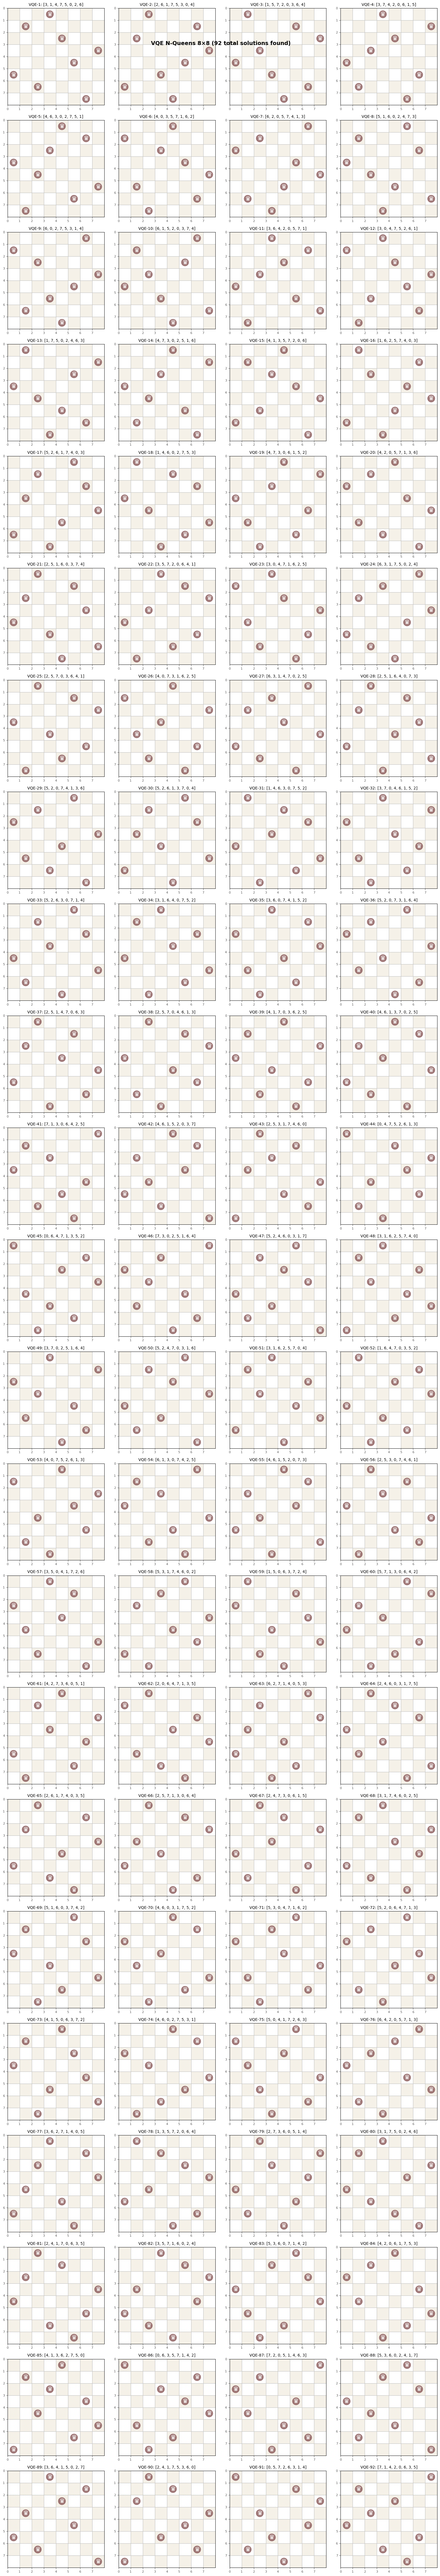

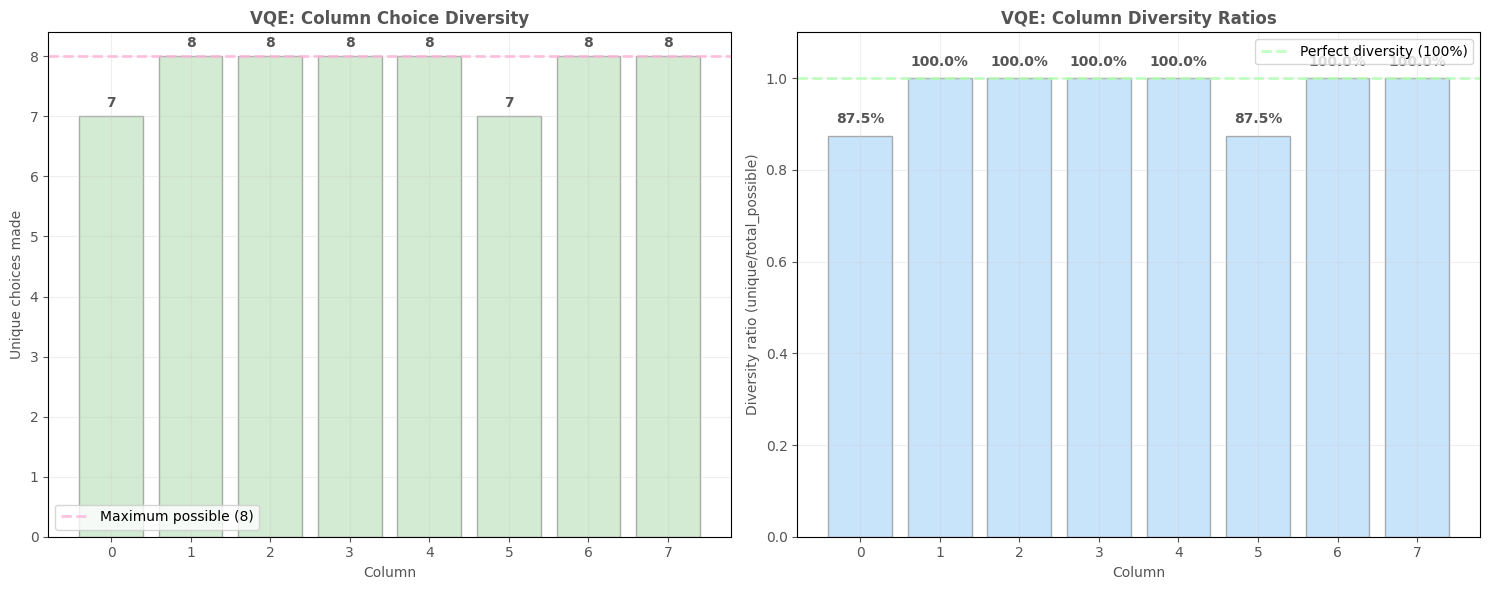


Detailed Column Diversity Analysis:
--------------------------------------------------
Column 0: 7/8 unique choices (87.5%)
  Choices made: [3, 3, 4, 4, 4, 3, 4, 5, 4, 3, 3, 3, 4, 3, 4, 5, 4, 2, 2, 2, 1, 4, 3, 6, 7, 3, 5, 4, 4, 6, 2, 3, 5, 4, 6, 6, 3, 2, 3, 2, 4, 5, 1, 5, 1, 3, 2, 2, 5, 5, 1, 6, 3, 5, 1, 2, 4, 6, 5, 4, 6]
Column 1: 8/8 unique choices (100.0%)
  Choices made: [7, 5, 0, 0, 1, 5, 0, 1, 7, 1, 1, 7, 7, 5, 0, 2, 1, 5, 4, 6, 5, 7, 5, 3, 1, 1, 1, 1, 0, 1, 4, 7, 1, 2, 0, 3, 7, 4, 5, 4, 1, 2, 5, 3, 5, 6, 5, 5, 3, 1, 7, 1, 1, 3, 4, 5, 0, 1, 3, 1, 1]
Column 2: 8/8 unique choices (100.0%)
  Choices made: [0, 0, 7, 7, 3, 0, 3, 6, 3, 6, 6, 0, 3, 0, 3, 6, 5, 1, 1, 1, 0, 3, 0, 1, 3, 6, 6, 3, 7, 5, 1, 0, 6, 7, 2, 1, 0, 1, 0, 1, 7, 6, 0, 0, 7, 4, 7, 1, 0, 6, 5, 3, 4, 0, 6, 7, 3, 3, 0, 3, 3]
Column 3: 8/8 unique choices (100.0%)
  Choices made: [2, 4, 3, 5, 5, 4, 5, 0, 0, 2, 2, 4, 0, 4, 5, 3, 0, 6, 7, 7, 6, 0, 4, 7, 0, 2, 0, 5, 5, 2, 7, 2, 0, 3, 7, 4, 2, 7, 4, 7, 0, 1, 6, 4, 2, 1, 0, 4, 

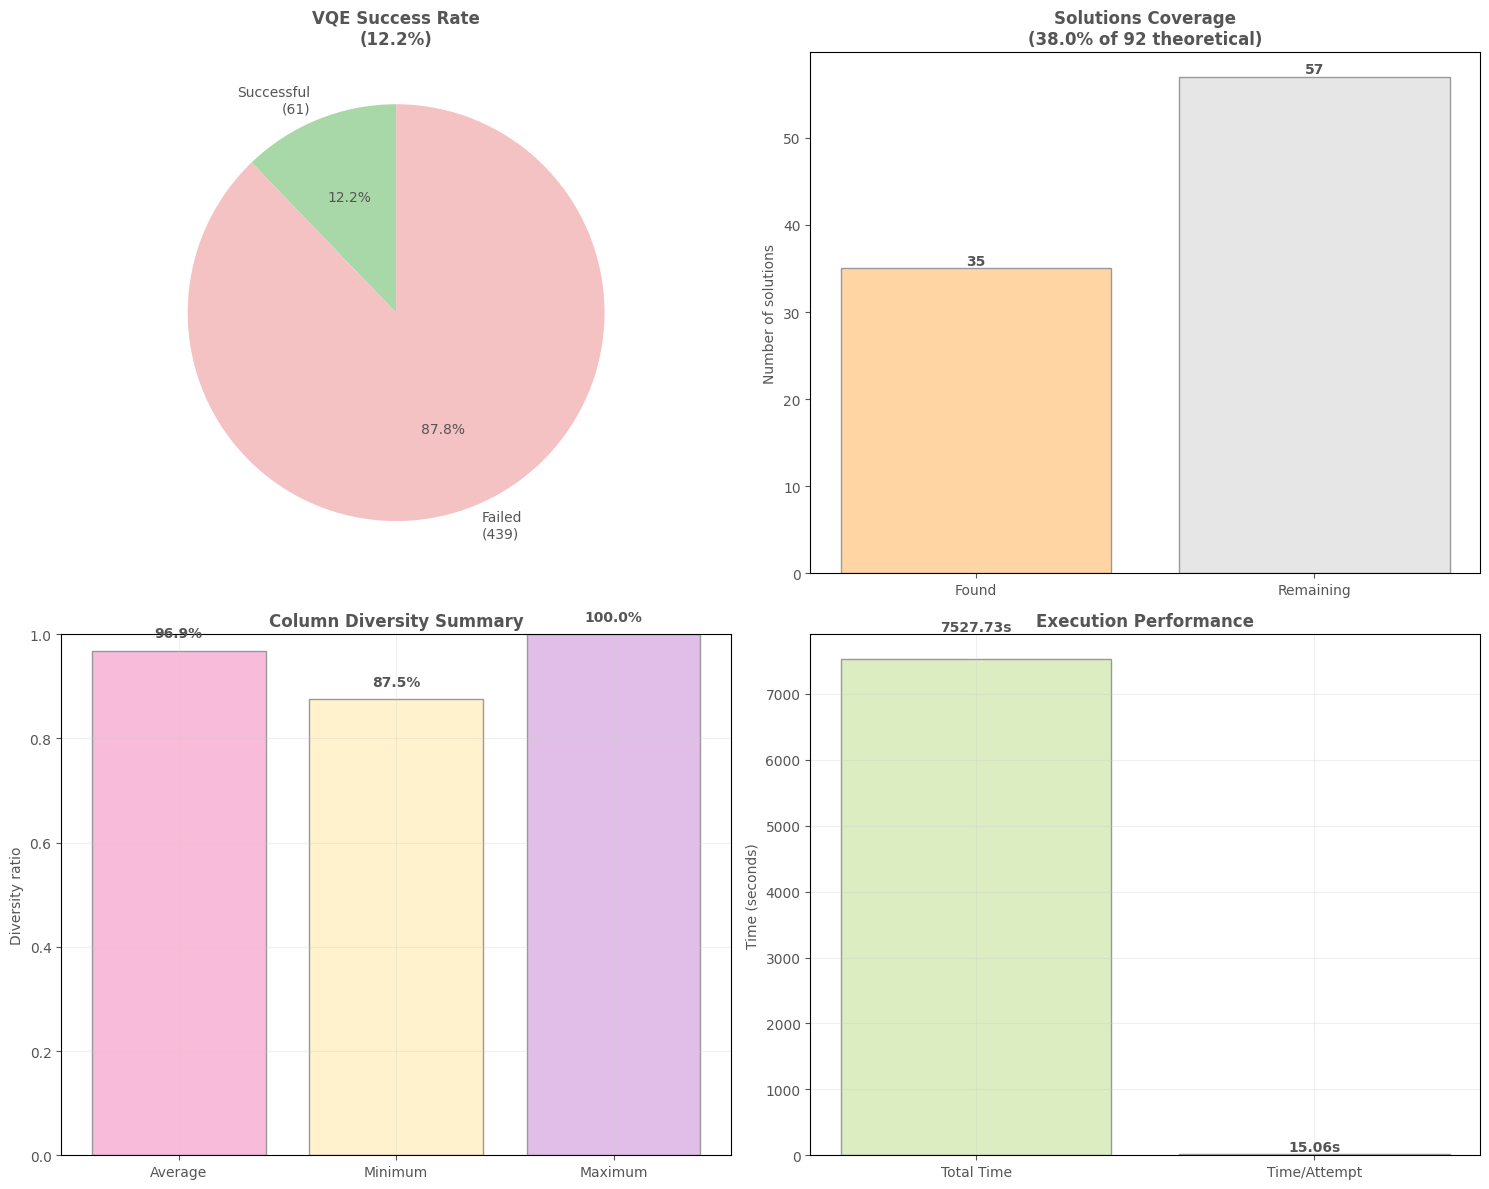


Solutions found:
  VQE-1: [3, 1, 4, 7, 5, 0, 2, 6]
  VQE-2: [2, 6, 1, 7, 5, 3, 0, 4]
  VQE-3: [1, 5, 7, 2, 0, 3, 6, 4]
  VQE-4: [3, 7, 4, 2, 0, 6, 1, 5]
  VQE-5: [4, 6, 3, 0, 2, 7, 5, 1]
  VQE-6: [4, 0, 3, 5, 7, 1, 6, 2]
  VQE-7: [6, 2, 0, 5, 7, 4, 1, 3]
  VQE-8: [5, 1, 6, 0, 2, 4, 7, 3]
  VQE-9: [6, 0, 2, 7, 5, 3, 1, 4]
  VQE-10: [6, 1, 5, 2, 0, 3, 7, 4]
  VQE-11: [3, 6, 4, 2, 0, 5, 7, 1]
  VQE-12: [3, 0, 4, 7, 5, 2, 6, 1]
  VQE-13: [1, 7, 5, 0, 2, 4, 6, 3]
  VQE-14: [4, 7, 3, 0, 2, 5, 1, 6]
  VQE-15: [4, 1, 3, 5, 7, 2, 0, 6]
  VQE-16: [1, 6, 2, 5, 7, 4, 0, 3]
  VQE-17: [5, 2, 6, 1, 7, 4, 0, 3]
  VQE-18: [1, 4, 6, 0, 2, 7, 5, 3]
  VQE-19: [4, 7, 3, 0, 6, 1, 5, 2]
  VQE-20: [4, 2, 0, 5, 7, 1, 3, 6]
  VQE-21: [2, 5, 1, 6, 0, 3, 7, 4]
  VQE-22: [3, 5, 7, 2, 0, 6, 4, 1]
  VQE-23: [3, 0, 4, 7, 1, 6, 2, 5]
  VQE-24: [6, 3, 1, 7, 5, 0, 2, 4]
  VQE-25: [2, 5, 7, 0, 3, 6, 4, 1]
  VQE-26: [4, 0, 7, 3, 1, 6, 2, 5]
  VQE-27: [6, 3, 1, 4, 7, 0, 2, 5]
  VQE-28: [2, 5, 1, 6, 4, 0, 7, 3]
  VQE-29: [

In [8]:
display_vqe_results(unique_withrotate_solutions, stats, size=size, max_display=len_display)